# Lab 1 _Poisson Regression

Try to use both `SK_learn` and `statmodels` libraries.

A data set of counts has the following characteristics:

1. Whole number data: The data consists of non-negative integers: [0… ∞] Regression techniques such as Ordinary Least Squares Regression may not be appropriate for modeling such data as OLSR works best on real numbers such as -656.0, -0.00000345, 13786.1 etc.
2. Skewed Distribution: The data may contain a large number of data points for just a few values, thereby making the frequency distribution quite skewed. See for example above histogram.
3. Sparsity: The data may reflect the occurrence of a rare event such as a gamma ray burst, thereby making the data sparse.
4. Rate of occurrence: For the sake of creating a model, it can be assumed that there is a certain rate of occurrence of events λ that drives the generation of such data. The event rate may drift over time.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numpy import exp
from scipy.special import factorial
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.stats import norm


/var/folders/29/wq14mrc56b72ty43ycw_32yr0000gn/T/ipykernel_22572/1782538796.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import statsmodels.api as sm
from statsmodels.api import Poisson
from statsmodels.iolib.summary2 import summary_col
from sklearn.linear_model import PoissonRegressor

In [3]:
import random
import math

In [4]:
from patsy import dmatrices

## Time Series Analysis, Regression and Forecasting 

### Example

Here, we use the cleaned data. The raw data are avilable here: https://data.cityofnewyork.us/Transportation/Bicycle-Counters/smn3-rzf9

In [5]:
df = pd.read_csv('nyc_bb_bicyclist_counts.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
df

/var/folders/29/wq14mrc56b72ty43ycw_32yr0000gn/T/ipykernel_22572/2715750610.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('nyc_bb_bicyclist_counts.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
/var/folders/29/wq14mrc56b72ty43ycw_32yr0000gn/T/ipykernel_22572/2715750610.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('nyc_bb_bicyclist_counts.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])


,HIGH_T,LOW_T,PRECIP,BB_COUNT
Date,,,,
2017-04-01,46.0,37.0,0.00,606
2017-04-02,62.1,41.0,0.00,2021
2017-04-03,63.0,50.0,0.03,2470
2017-04-04,51.1,46.0,1.18,723
2017-04-05,63.0,46.0,0.00,2807
...,...,...,...,...
2017-10-27,62.1,48.0,0.00,3150
2017-10-28,68.0,55.9,0.00,2245
2017-10-29,64.9,61.0,3.03,183


We’ll add a few derived regression variables to the X matrix.

In [6]:
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day

In [7]:
df

,HIGH_T,LOW_T,PRECIP,BB_COUNT,MONTH,DAY_OF_WEEK,DAY
Date,,,,,,,
2017-04-01,46.0,37.0,0.00,606,4,5,1
2017-04-02,62.1,41.0,0.00,2021,4,6,2
2017-04-03,63.0,50.0,0.03,2470,4,0,3
2017-04-04,51.1,46.0,1.18,723,4,1,4
2017-04-05,63.0,46.0,0.00,2807,4,2,5
...,...,...,...,...,...,...,...
2017-10-27,62.1,48.0,0.00,3150,10,4,27
2017-10-28,68.0,55.9,0.00,2245,10,5,28
2017-10-29,64.9,61.0,3.03,183,10,6,29


We will not use the Date variable as a regressor since it contains an absolute date value but we don’t need to do anything special to drop Date as it is already consumed as the index of the pandas DataFrame. So it will not be available to us in the X matrix.

Let’s create the training and testing data sets.

In [8]:
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=182
Testing data set length=32


Setup the regression expression in patsy notation. We are telling patsy that BB_COUNT is our dependent variable and it depends on the regression variables: DAY, DAY_OF_WEEK, MONTH, HIGH_T, LOW_T and PRECIP.

In [9]:
expr = """BB_COUNT ~ DAY  + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP"""

Set up the X and y matrices for the training and testing data sets. patsy makes this really simple.

In [10]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

Using the statsmodels GLM class, train the Poisson regression model on the training data set.

In [11]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

Print the training summary.

In [12]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  182
Model:                            GLM   Df Residuals:                      175
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14152.
Date:                Sun, 11 Feb 2024   Deviance:                       26550.
Time:                        10:32:45   Pearson chi2:                 2.65e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.0320      0.012    591.911      

The summary() method on the statsmodels GLMResults class shows a couple of useful goodness-of-fit statistics to help you evaluate whether your Poisson regression model was able to successfully fit the training data. (e.g., Deviance, Pearson Chi2)

The low performance of the model was because the data did not obey the variance = mean criterion required of it by the Poisson regression model. (Negative Binomial model is another choice)

This rather strict criterion is often not satisfied by real world data. Often, the variance is greater than the mean, a property called over-dispersion, and sometimes the variance is less than the mean, called under-dispersion. In such cases, one needs to use a regression model that will not make the equi-dispersion assumption i.e.not assume that variance=mean.

### So how well did our model do? Let’s make some predictions on the test data set.

In [13]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

                   mean    mean_se  mean_ci_lower  mean_ci_upper
Date                                                            
2017-04-06  1132.169495   7.266436    1118.016745    1146.501402
2017-04-20  2270.629776   7.483590    2256.009481    2285.344820
2017-05-04  2494.823293   8.154121    2478.892590    2510.856375
2017-05-15  2692.028966   8.566117    2675.291931    2708.870710
2017-05-24  2465.187501   7.005034    2451.496048    2478.955420
2017-05-27  2487.754275   8.228751    2471.678385    2503.934724
2017-06-01  3044.589180   9.449228    3026.125247    3063.165770
2017-06-02  2750.582263   8.102693    2734.747035    2766.509183
2017-06-14  2593.155485   7.937746    2577.644364    2608.759945
2017-06-19  1264.656476  13.877884    1237.746747    1292.151247
2017-06-20  2966.163985   8.501691    2949.547693    2982.873884
2017-06-26  3094.092389   9.942567    3074.666553    3113.640959
2017-07-03  2527.583597  12.993919    2502.243857    2553.179946
2017-07-04  3223.556569  

Each row: The first column is the date. The second column is the prediciton fo the mean. The third column is the standard error for the mean. The last two columns are teh 95% confidence interval.

Let’s plot the predicted counts versus the actual counts for the test data.

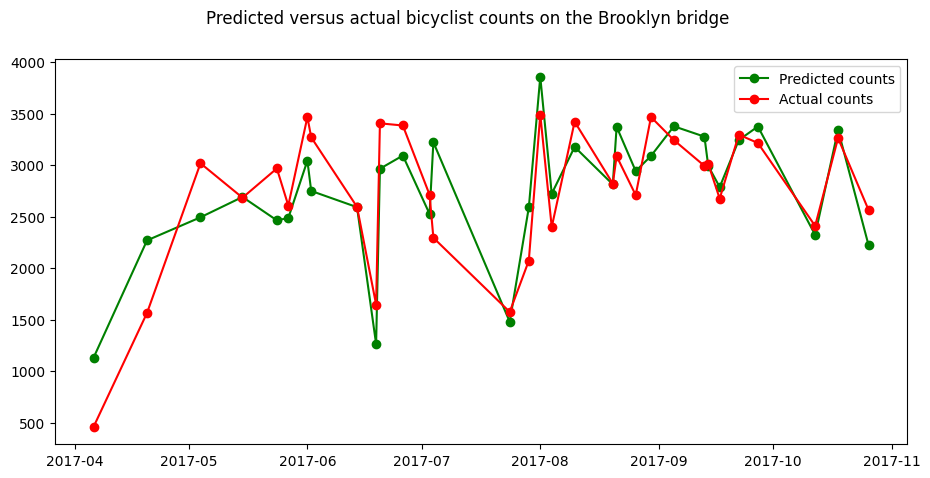

In [14]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

The model seems to be more or less tracking the trend in the actual counts although in many cases its predictions are way off the actual value.

Let’s also plot Actual versus Predicted counts.

<Figure size 1100x500 with 0 Axes>

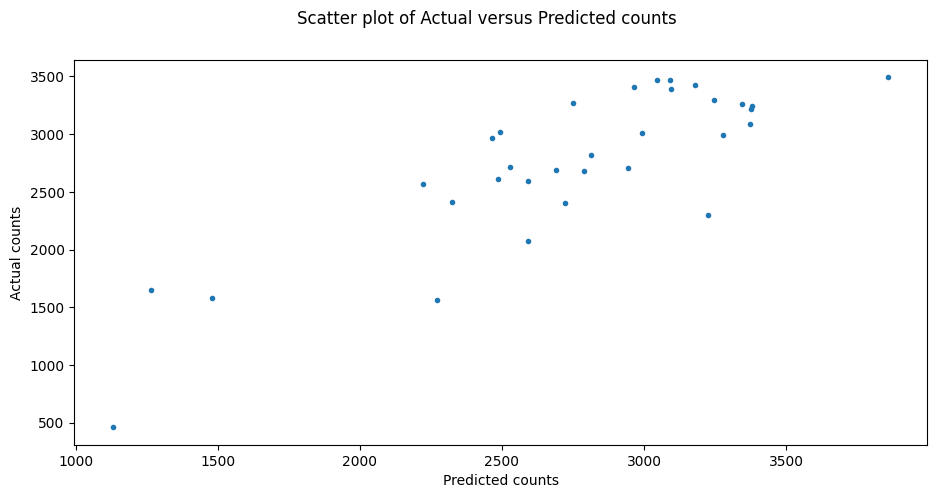

In [15]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

# Traffic Accident Data Set:

Data Sets: 

1. US Accidents (2016 - 2021)

A Countrywide Traffic Accident Dataset (2016 - 2021)

https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents?select=US_Accidents_Dec21_updated.csv  (Data is 1.2G)

Feature information: US-Accidents: A Countrywide Traffic Accident Dataset Description: 
https://smoosavi.org/datasets/us_accidents


2. Accidents in France from 2005 to 2016 (for yourself in future study)

https://www.kaggle.com/datasets/ahmedlahlou/accidents-in-france-from-2005-to-2016 

# Questions:  

#### 1. Use US Accidents (2016 - 2021) data, summerize by daily, use Temperature(F), Precipitation(in), Wind_Speed(mph), humidity (in percentage).  

#### 2. Use Possion regression to model the daily accident in the US (or in one state data, or one city data, or only use 1 year data, if your computer is not powerful enough ) 

#### or 3, You can also summerize your own question, but you need to use possion regression to model the data

Kaggle has several good notebooks in python: 
For example, https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents/code?select=US_Accidents_Dec21_updated.csv and find in `Code`

One example for Cleveland, OH.
https://www.kaggle.com/code/sekoukeita/analysis-and-visualization-for-us-and-cleveland-oh


#### or 4. If you feel difficult of dealing with the raw data above, you can start with a similar example from below:
Daily total of bike counts conducted monthly on the Brooklyn Bridge, Manhattan Bridge, Williamsburg Bridge, and Queensboro Bridge.
https://data.cityofnewyork.us/Transportation/Bicycle-Counts-for-East-River-Bridges-Historical-/gua4-p9wg 

In [50]:
df = pd.read_csv('US_Accidents_March23.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
#df = pd.read_csv('US_Accidents_March23_sampled_500k.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])

/var/folders/29/wq14mrc56b72ty43ycw_32yr0000gn/T/ipykernel_22572/2045475522.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('US_Accidents_March23.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
/var/folders/29/wq14mrc56b72ty43ycw_32yr0000gn/T/ipykernel_22572/2045475522.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('US_Accidents_March23.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])


In [51]:
df

,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
ID,,,,,,,,,,,,,,,,,,,,,
A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.010,Right lane blocked due to accident on I-70 Eas...,...,False,False,False,False,False,False,Night,Night,Night,Night
A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.010,Accident on Brice Rd at Tussing Rd. Expect del...,...,False,False,False,False,False,False,Night,Night,Night,Day
A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.010,Accident on OH-32 State Route 32 Westbound at ...,...,False,False,False,False,True,False,Night,Night,Day,Day
A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.010,Accident on I-75 Southbound at Exits 52 52B US...,...,False,False,False,False,False,False,Night,Day,Day,Day
A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.010,Accident on McEwen Rd at OH-725 Miamisburg Cen...,...,False,False,False,False,True,False,Day,Day,Day,Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A-7777757,Source1,2,2019-08-23 18:03:25,2019-08-23 18:32:01,34.002480,-117.379360,33.99888,-117.37094,0.543,At Market St - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day
A-7777758,Source1,2,2019-08-23 19:11:30,2019-08-23 19:38:23,32.766960,-117.148060,32.76555,-117.15363,0.338,At Camino Del Rio/Mission Center Rd - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day
A-7777759,Source1,2,2019-08-23 19:00:21,2019-08-23 19:28:49,33.775450,-117.847790,33.77740,-117.85727,0.561,At Glassell St/Grand Ave - Accident. in the ri...,...,False,False,False,False,False,False,Day,Day,Day,Day


In [52]:
df['City'].value_counts()

City
Miami                           186917
Houston                         169609
Los Angeles                     156491
Charlotte                       138652
Dallas                          130939
                                 ...  
Benkelman                            1
Old Appleton                         1
Wildrose                             1
Mc Nabb                              1
American Fork-Pleasant Grove         1
Name: count, Length: 13678, dtype: int64

Here, we extract the Houston's data and then take the average of each day's humidity, temperature and wind speed.

In [53]:
df_Miami = df[df['City'] == 'Miami']

In [54]:
df_Miami

,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
ID,,,,,,,,,,,,,,,,,,,,,
A-116064,Source2,2,2016-11-30 16:40:31,2016-11-30 17:10:19,25.627699,-80.374451,NaN,NaN,0.010,Accident on FL-992 152nd St at Lincoln Blvd.,...,False,False,True,False,True,False,Day,Day,Day,Day
A-116067,Source2,2,2016-11-30 15:16:19,2016-11-30 17:01:03,25.963093,-80.185677,NaN,NaN,0.010,Left turn lane blocked due to accident on FL-8...,...,False,False,False,False,True,False,Day,Day,Day,Day
A-116068,Source2,2,2016-11-30 16:55:31,2016-11-30 17:25:11,25.841373,-80.322037,NaN,NaN,0.010,Queueing traffic due to accident on FL-826 Pal...,...,False,False,False,False,False,False,Day,Day,Day,Day
A-116069,Source2,3,2016-11-30 16:57:23,2016-11-30 17:27:10,25.812199,-80.205856,NaN,NaN,0.010,Accident on I-95 Southbound at Exits 4 4B FL-1...,...,False,False,False,False,False,False,Day,Day,Day,Day
A-116071,Source2,2,2016-11-30 17:15:52,2016-11-30 17:45:36,25.781235,-80.337181,NaN,NaN,0.010,Queueing traffic due to accident on FL-836 Dol...,...,False,False,False,False,False,False,Day,Day,Day,Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A-7776983,Source1,2,2019-08-22 17:10:33,2019-08-22 17:38:17,25.707554,-80.285429,25.708083,-80.284736,0.057,At SR-959/Red Rd/57th Ave - Accident.,...,False,False,False,False,True,False,Day,Day,Day,Day
A-7776984,Source1,4,2019-08-22 17:12:48,2019-08-22 17:42:07,25.909390,-80.209870,25.912360,-80.209700,0.205,Ramp closed to 151st St/Exit 11 - Road closed ...,...,False,False,False,False,False,False,Day,Day,Day,Day
A-7777410,Source1,4,2019-08-23 02:01:46,2019-08-23 02:30:39,25.927371,-80.212694,25.927371,-80.212694,0.000,Ramp to SR-826/Florida's Tpke/R Reagan Tpke - ...,...,False,False,False,False,False,False,Night,Night,Night,Night


In [55]:
df = df_Miami

In [56]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='ISO8601')
df['Date'] = df['Start_Time'].dt.date

# Group by 'Date' and calculate the accident count and mean for specified columns
daily_summary = df.groupby('Date', dropna=True).agg(
    Accident_Count=('Start_Time', 'size'),  # Count the number of accidents
    Temperature_Mean=('Temperature(F)', 'mean'),  # Average temperature
    Humidity_Mean=('Humidity(%)', 'mean'),  # Average humidity
    Wind_Speed_Mean=('Wind_Speed(mph)', 'mean'),  # Average wind speed
    Precipitation_Mean=('Precipitation(in)', 'mean')
).reset_index()

# Now, daily_summary DataFrame contains one row per day with the accident count and average weather conditions

# If you also need to add 'DAY', 'DAY_OF_WEEK', and 'MONTH' columns based on 'Date', you can do:
daily_summary['DAY'] = daily_summary['Date'].apply(lambda x: x.day)
daily_summary['DAY_OF_WEEK'] = daily_summary['Date'].apply(lambda x: x.weekday())  # Monday=0, Sunday=6
daily_summary['MONTH'] = daily_summary['Date'].apply(lambda x: x.month)

/var/folders/29/wq14mrc56b72ty43ycw_32yr0000gn/T/ipykernel_22572/3238644147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='ISO8601')
/var/folders/29/wq14mrc56b72ty43ycw_32yr0000gn/T/ipykernel_22572/3238644147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Start_Time'].dt.date


In [57]:
daily_summary.dropna(inplace=True)
daily_summary

,Date,Accident_Count,Temperature_Mean,Humidity_Mean,Wind_Speed_Mean,Precipitation_Mean,DAY,DAY_OF_WEEK,MONTH
0,2016-06-17,3,80.066667,76.333333,13.033333,0.110000,17,4,6
1,2016-06-21,25,78.384000,84.160000,10.091667,0.078235,21,1,6
3,2016-06-23,48,84.677083,71.083333,7.469048,0.023333,23,3,6
7,2016-06-27,28,83.775000,69.142857,6.463636,0.010000,27,0,6
8,2016-06-28,36,84.683333,67.027778,6.712500,0.006667,28,1,6
...,...,...,...,...,...,...,...,...,...
2385,2023-02-27,1,75.000000,64.000000,3.000000,0.000000,27,0,2
2386,2023-03-19,1,68.000000,87.000000,0.000000,0.000000,19,6,3
2387,2023-03-20,1,60.000000,96.000000,9.000000,0.000000,20,0,3
2388,2023-03-26,2,85.000000,59.000000,10.000000,0.000000,26,6,3


In [58]:
summary = daily_summary.describe()
print(summary)

       Accident_Count  Temperature_Mean  Humidity_Mean  Wind_Speed_Mean  \
count     1917.000000       1917.000000    1917.000000      1917.000000   
mean        92.037037         79.328021      71.777021         9.047528   
std        113.887568          6.239385       9.254743         3.405558   
min          1.000000         47.200000      33.045455         0.000000   
25%         20.000000         76.059925      65.653846         6.634146   
50%         36.000000         80.115385      72.173913         8.666667   
75%        129.000000         83.996875      78.000000        11.130435   
max        818.000000         90.714286      96.114286        30.500000   

       Precipitation_Mean          DAY  DAY_OF_WEEK        MONTH  
count         1917.000000  1917.000000  1917.000000  1917.000000  
mean             0.019893    15.658842     2.950965     6.719353  
std              0.058738     8.760823     1.973915     3.381070  
min              0.000000     1.000000     0.000000     

Here we use the data that is normal to train and test.

In [59]:
df_subset = daily_summary[(daily_summary['Accident_Count'] > 10) & (daily_summary['Accident_Count'] < 100)]

In [60]:
df_subset

,Date,Accident_Count,Temperature_Mean,Humidity_Mean,Wind_Speed_Mean,Precipitation_Mean,DAY,DAY_OF_WEEK,MONTH
1,2016-06-21,25,78.384000,84.160000,10.091667,0.078235,21,1,6
3,2016-06-23,48,84.677083,71.083333,7.469048,0.023333,23,3,6
7,2016-06-27,28,83.775000,69.142857,6.463636,0.010000,27,0,6
8,2016-06-28,36,84.683333,67.027778,6.712500,0.006667,28,1,6
9,2016-06-29,32,83.071875,74.125000,5.933333,0.020000,29,2,6
...,...,...,...,...,...,...,...,...,...
2378,2023-02-14,16,73.625000,55.812500,10.875000,0.000000,14,1,2
2380,2023-02-16,30,78.300000,63.866667,11.800000,0.000000,16,3,2
2382,2023-02-22,21,79.190476,65.285714,8.400000,0.000000,22,2,2
2383,2023-02-23,13,79.307692,69.000000,10.615385,0.000000,23,3,2


In [61]:
summary = df_subset.describe()
print(summary)

       Accident_Count  Temperature_Mean  Humidity_Mean  Wind_Speed_Mean  \
count     1083.000000       1083.000000    1083.000000      1083.000000   
mean        35.626039         79.563111      73.270495         8.976683   
std         20.230135          6.138864       8.259578         3.323841   
min         11.000000         47.200000      33.045455         1.691176   
25%         22.000000         76.490592      67.884584         6.672619   
50%         31.000000         80.652174      73.583333         8.642857   
75%         42.000000         84.031684      78.473011        10.988919   
max         99.000000         90.593750      95.360000        22.815152   

       Precipitation_Mean          DAY  DAY_OF_WEEK        MONTH  
count         1083.000000  1083.000000  1083.000000  1083.000000  
mean             0.025089    15.771006     2.810711     6.673130  
std              0.066597     8.784502     1.944754     3.169618  
min              0.000000     1.000000     0.000000     

In [62]:
mean = df_subset['Accident_Count'].mean()
std = df_subset['Accident_Count'].std()
print(mean, std)

35.62603878116344 20.230134951903977


In [63]:
#par = mean / (std ** 2)
par = 1
df_cutdown = df_subset
df_cutdown['Accident_Count'] *= par
summary = df_cutdown.describe()
print(summary)

       Accident_Count  Temperature_Mean  Humidity_Mean  Wind_Speed_Mean  \
count     1083.000000       1083.000000    1083.000000      1083.000000   
mean        35.626039         79.563111      73.270495         8.976683   
std         20.230135          6.138864       8.259578         3.323841   
min         11.000000         47.200000      33.045455         1.691176   
25%         22.000000         76.490592      67.884584         6.672619   
50%         31.000000         80.652174      73.583333         8.642857   
75%         42.000000         84.031684      78.473011        10.988919   
max         99.000000         90.593750      95.360000        22.815152   

       Precipitation_Mean          DAY  DAY_OF_WEEK        MONTH  
count         1083.000000  1083.000000  1083.000000  1083.000000  
mean             0.025089    15.771006     2.810711     6.673130  
std              0.066597     8.784502     1.944754     3.169618  
min              0.000000     1.000000     0.000000     

/var/folders/29/wq14mrc56b72ty43ycw_32yr0000gn/T/ipykernel_22572/3025248798.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cutdown['Accident_Count'] *= par


In [64]:
mask = np.random.rand(len(df_cutdown)) < 0.8
df_train = df_cutdown[mask]
df_test = df_cutdown[~mask]
print('Training data set length = ' + str(len(df_train)))
print('Testing data set length = ' + str(len(df_test)))

Training data set length = 871
Testing data set length = 212


In [65]:
expr = 'Accident_Count ~ Temperature_Mean + Humidity_Mean + Wind_Speed_Mean + Precipitation_Mean'

In [66]:
y_train, X_train = dmatrices(expr, df_train, return_type = 'dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type = 'dataframe')

In [67]:
poisson_training_results = sm.GLM(y_train, X_train, family= sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         Accident_Count   No. Observations:                  871
Model:                            GLM   Df Residuals:                      866
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6714.9
Date:                Sun, 11 Feb 2024   Deviance:                       8840.7
Time:                        10:57:02   Pearson chi2:                 9.83e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.08895
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.1379      0

In [68]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

           mean   mean_se  mean_ci_lower  mean_ci_upper
10    34.799106  0.289116      34.237037      35.370402
17    37.334490  0.503045      36.361444      38.333575
25    35.513194  0.310969      34.908906      36.127942
28    36.326721  0.609953      35.150692      37.542097
32    34.445099  0.311742      33.839482      35.061554
...         ...       ...            ...            ...
2289  34.934391  0.216581      34.512468      35.361472
2296  37.151870  0.411650      36.353748      37.967515
2302  36.301499  0.273311      35.769753      36.841150
2341  35.549683  0.257103      35.049326      36.057184
2382  37.251111  0.303342      36.661291      37.850421

[212 rows x 4 columns]


In [69]:
print(predictions_summary_frame['mean'].describe())

count    212.000000
mean      35.475070
std        1.908151
min       28.652705
25%       34.510892
50%       35.418658
75%       36.307805
max       46.110705
Name: mean, dtype: float64


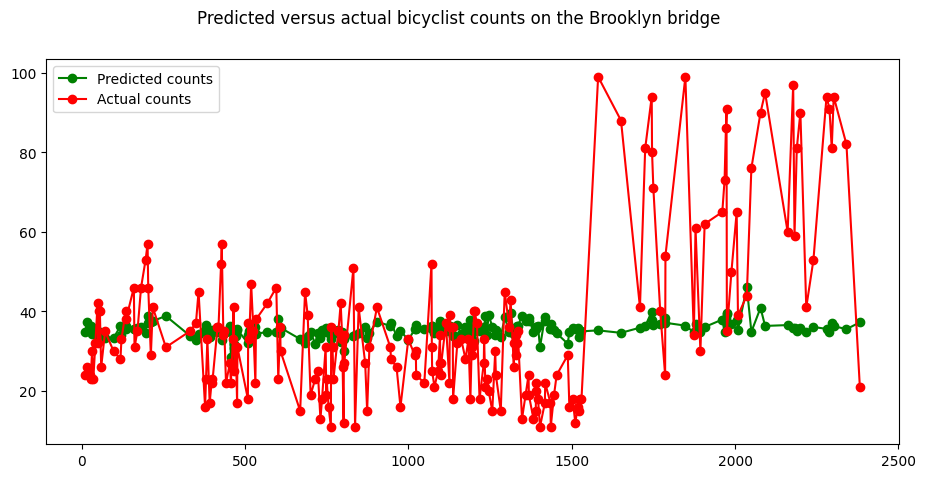

In [70]:
predicted_counts=predictions_summary_frame['mean'] * (1 / par)
actual_counts = y_test['Accident_Count'] * (1 / par)
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

<Figure size 1100x500 with 0 Axes>

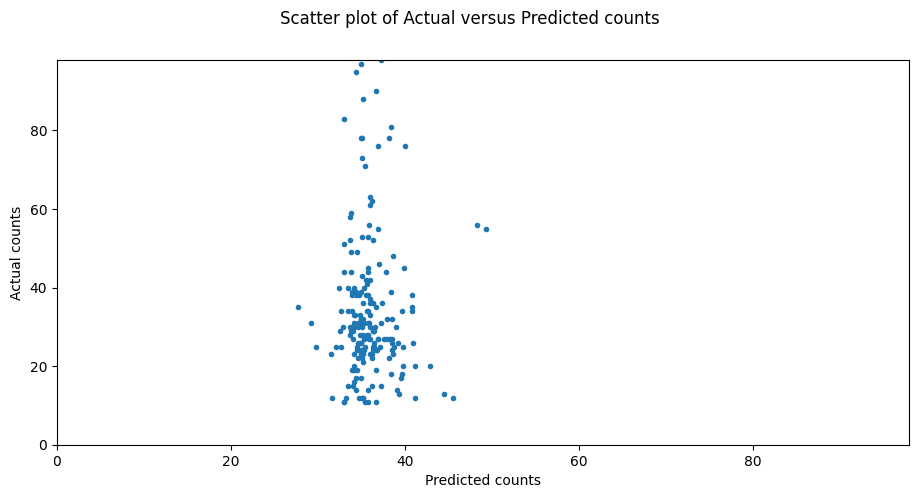

In [48]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
# Set the axes to include (0, 0) explicitly
plt.xlim([min(0, predicted_counts.min()), max(predicted_counts.max(), actual_counts.max())])
plt.ylim([min(0, actual_counts.min()), max(predicted_counts.max(), actual_counts.max())])
plt.show()

We can see that there's still lots of room for improvement. Since the data's variance and mean are not much likely. But from the graph we can see that the predicted mean is about the mean of the actual data. While the variance is much more underestimated than the truth. It might be the reason that the raw data's mean is much less than the variance or the choosen column is not very related to the prediction.